# NLP Speech Sentiment Analysis: Model

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import re
#import nltk
#from nltk.tokenize import word_tokenize
#from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report


#from keras.preprocessing import sequence

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import *
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer

#from sklearn.model_selection import train_test_split

#### Import datasets

In [2]:
# Import preprocessed datasets ('data_preprocess.ipynb')

# Preprocessed version of GoEmotions: A Dataset of Fine-Grained Emotions (GoEmotions 1, 2, and 3 merged)
# Reference: Demszky, Dorottya and Movshovitz-Attias, Dana and Ko, Jeongwoo and Cowen, Alan and Nemade, Gaurav and Ravi, Sujith, https://github.com/google-re
goe = pd.read_csv('data/goe_merged.csv')

# Preprocessed version of Emotion Classification dataset
# Reference: https://www.kaggle.com/datasets/abdallahwagih/emotion-dataset
ed = pd.read_csv('data/ed.csv')

# Preprocessed version of Emotions dataset
# Reference: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
emo = pd.read_csv('data/emo.csv')

# Preprocessed version of Sentiment140 dataset 
# Reference: https://www.kaggle.com/datasets/kazanova/sentiment140
twit = pd.read_csv('data/sent.csv')

## Helper functions

## Preprocessing

In [3]:
# Concatenate all datasets
df = pd.concat([goe, ed, emo, twit], ignore_index=True)

# Display dataframe summary
df

,text,Emotion
0,that game hurt,sadness
1,so happy for name so sad hes not here imagine ...,disgust
2,sending love and strength vibes,joy
3,no were getting kinsler and be happy with it,joy
4,omg lala a housewife i cant even imagine,surprise
...,...,...
827760,mshiphop im glad ur doing well,joy
827761,rmedina latati mmmm that sounds absolutely per...,disgust
827762,cliffforster yeah that does work better than j...,surprise
827763,happy th birthday to my boo of alll time tupac...,joy


In [4]:
# Map string emotions to integer label values
# Emotion mapping dictionary
emotion_map = {'disgust': 0, 'fear': 1, 'anger': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}

# Apply integer mapping to the 'Emotion' column
df['Emotion'] = df['Emotion'].map(emotion_map)

# Display head of dataframe
df.head()

,text,Emotion
0,that game hurt,4
1,so happy for name so sad hes not here imagine ...,0
2,sending love and strength vibes,3
3,no were getting kinsler and be happy with it,3
4,omg lala a housewife i cant even imagine,5


In [5]:
# Split data into texts and emotion labels
texts = df['text']
emotions = df['Emotion']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(texts, emotions, test_size=0.2, random_state=42, shuffle=True)

# Initialize tokenizer, fit on the training data, and convert text data to sequences
tokenizer = Tokenizer(num_words=100000, oov_token="<OOV>")   # Tokenize with all words included 
tokenizer.fit_on_texts(x_train)                              # Fit tokenizer
vocabulary_size = len(tokenizer.word_index)                  # Get the vocabulary size
print("Vocabulary size: ", vocabulary_size)                  # Print the vocabulary size
tokenizer_train_seq = tokenizer.texts_to_sequences(x_train)  # Converts x_train text to sequences
tokenizer_test_seq = tokenizer.texts_to_sequences(x_test)    # Converts x_test text to sequences

# Determine the maximum length of the x_train sequence for padding and input shape 
seq_length = max(map(len, tokenizer_train_seq))              # Max length
print("seq_length: ", seq_length)                            # Print max length

# Pad sequences (ensures uniform length)
X_train = pad_sequences(tokenizer_train_seq, maxlen=seq_length, padding='post', truncating='post')  # Pad x_train sequence
X_test = pad_sequences(tokenizer_test_seq, maxlen=seq_length, padding='post', truncating='post')    # Pad x_testt sequence

# Print shapes of training and test data
print(f"Training shape:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test shape:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Vocabulary size:  277797
seq_length:  178
Training shape:
X_train: (662212, 178), y_train: (662212,)
Test shape:
X_test: (165553, 178), y_test: (165553,)


## Build model

In [6]:
# Define the model
model = Sequential()

# Embedding layer with a output dimension of 256 (converts words into dense vectors)
model.add(Embedding(input_dim=vocabulary_size + 1, output_dim=256, input_length=seq_length))

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(256, return_sequences=False)))

# Batch normalization
model.add(BatchNormalization())

# Dropout layer for regularization (50% probability)
model.add(Dropout(0.5))

# Dense layer with 128 units
model.add(Dense(128, activation='relu'))

# Dropout layer for regularization (50% probability)
model.add(Dropout(0.5))

# Output layer with the 6 emotion classes, using softmax activation for the multi-class classification
model.add(Dense(6, activation='softmax'))

# Compile the model using adam and sparse categorical crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 178, 256)          71116288  
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1050624   
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

## Train model

In [7]:
# Early stop 
early_stop = EarlyStopping(
    monitor='val_accuracy',  # Value to monitor
    patience=3,              # Wait for 3 epochs
    verbose=1,               # Verbosity
    mode="max",              # Mode
    restore_best_weights=True
)

# Learning rate reduction 
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss', # Value to monitor
    factor=0.4,         # Reduction factor
    patience=3,         # Wait for 5 epochs
    verbose=1,          # Verbosity
    mode='min',         # Mode
    min_lr=1e-6         # Minimum learning rate
) 

# Save the best model observed
model_checkpoint = ModelCheckpoint(
    'NLP_model.h5',          # Model export filename
    monitor="val_accuracy",  # Value to monitor
    verbose=1,               # Verbosity
    mode="max",              # Mode
    save_best_only=True      # Save when the best model is observed
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    callbacks=[early_stop, lr_reduction, model_checkpoint],  
    validation_data=(X_test, y_test)
)

Epoch 1/20
20694/20695 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9532
Epoch 1: val_accuracy improved from -inf to 0.97760, saving model to NLP_model.h5
20695/20695 [==============================] - 1153s 56ms/step - loss: 0.1331 - accuracy: 0.9532 - val_loss: 0.0488 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 2/20
20694/20695 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9757
Epoch 2: val_accuracy improved from 0.97760 to 0.97822, saving model to NLP_model.h5
20695/20695 [==============================] - 1145s 55ms/step - loss: 0.0612 - accuracy: 0.9757 - val_loss: 0.0480 - val_accuracy: 0.9782 - lr: 0.0010
Epoch 3/20
20694/20695 [============================>.] - ETA: 0s - loss: 0.0550 - accuracy: 0.9775
Epoch 3: val_accuracy improved from 0.97822 to 0.97903, saving model to NLP_model.h5
20695/20695 [==============================] - 1130s 55ms/step - loss: 0.0550 - accuracy: 0.9775 - val_loss: 0.0470 - val_accuracy: 0.9790 - lr:

## Evaluate model

### Accuracy and Loss Plot

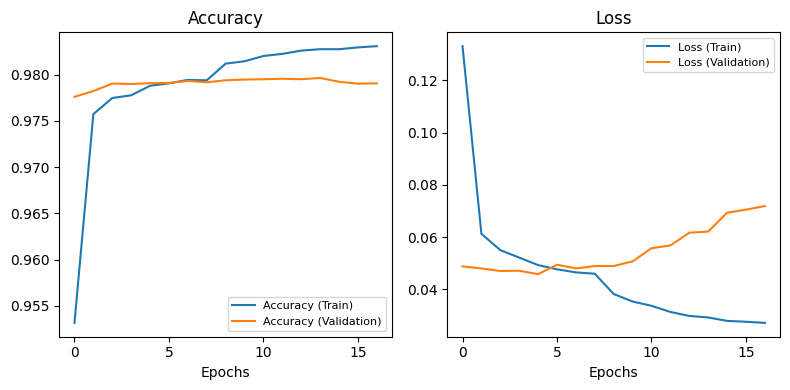

In [8]:
plt.figure(figsize=(8, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (Train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend(prop={'size': 8})

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend(prop={'size': 8})

plt.tight_layout()
plt.show()

### Calculate metrics

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Test predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test, y_pred, average='weighted')  # Precision
recall = recall_score(y_test, y_pred, average='weighted')        # Recall
f1 = f1_score(y_test, y_pred, average='weighted')                # F1 score

# Print results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

5174/5174 [==============================] - 39s 8ms/step
Test Accuracy: 0.9796
Test Loss: 0.0621
Precision: 0.9801
Recall: 0.9796
F1 Score: 0.9794


### Confusion matrix

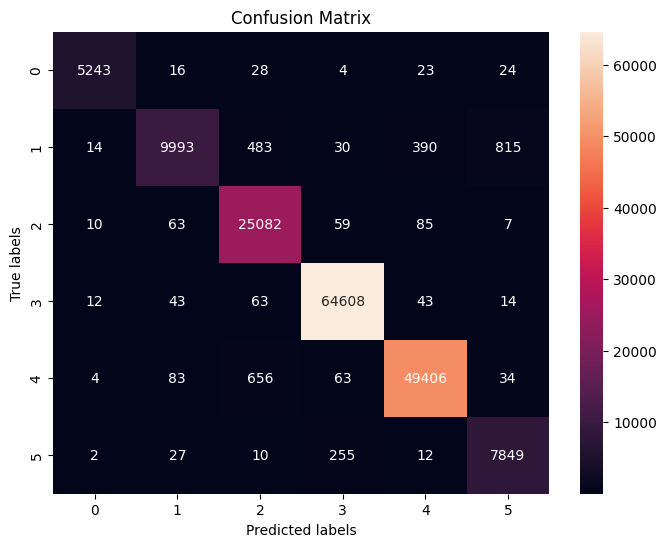

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Classification report

In [12]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5338
           1       0.98      0.85      0.91     11725
           2       0.95      0.99      0.97     25306
           3       0.99      1.00      1.00     64783
           4       0.99      0.98      0.99     50246
           5       0.90      0.96      0.93      8155

    accuracy                           0.98    165553
   macro avg       0.97      0.96      0.96    165553
weighted avg       0.98      0.98      0.98    165553



## Conclusion